In [35]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import joblib
from xgboost import XGBRegressor
import datetime
from sklearn.preprocessing import MinMaxScaler


# Load the datasets
train = pd.read_csv("train.csv")
store = pd.read_csv("store.csv")

# Merge datasets
data = pd.merge(train, store, on="Store", how="left")
print(data.head())


<ipython-input-35-1de42afd8b76>:18: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("train.csv")


   Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  \
0              1         c          a               1270.0   
1              1         a          a                570.0   
2              1         a          a              14130.0   
3              1         c          c                620.0   
4              1         a          a              29910.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0       0   
1                   

In [9]:
print(data.isnull().sum())

#Fill missing values in `CompetitionDistance` and other columns
data['CompetitionDistance'] = data['CompetitionDistance'].fillna(data['CompetitionDistance'].median())
data['CompetitionOpenSinceMonth'] = data['CompetitionOpenSinceMonth'].fillna(0)
data['CompetitionOpenSinceYear'] = data['CompetitionOpenSinceYear'].fillna(0)
data['Promo2SinceWeek'] = data['Promo2SinceWeek'].fillna(0)
data['Promo2SinceYear'] = data['Promo2SinceYear'].fillna(0)
data['PromoInterval'] = data['PromoInterval'].fillna("None")


Store                        0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64


In [10]:
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['Weekday'] = data['Date'].dt.weekday
data['IsWeekend'] = data['Weekday'].apply(lambda x: 1 if x >= 5 else 0)
data['MonthSegment'] = data['Day'].apply(lambda x: 0 if x <= 10 else (1 if x <= 20 else 2))


In [11]:
# Encode PromoInterval
promo_months = {'None': [], 'Jan,Apr,Jul,Oct': [1, 4, 7, 10], 'Feb,May,Aug,Nov': [2, 5, 8, 11], 'Mar,Jun,Sept,Dec': [3, 6, 9, 12]}
data['IsPromoMonth'] = data.apply(lambda x: 1 if x['Month'] in promo_months[x['PromoInterval']] else 0, axis=1)


In [16]:
for col in categorical_columns:
    print(f"{col} unique values and types:")
    print(data[col].apply(type).unique())
for col in categorical_columns:
    data[col] = data[col].astype(str)
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
for col in categorical_columns:
    data[col] = encoder.fit_transform(data[col])
for col in categorical_columns:
    print(f"Encoded values for {col}:")
    print(data[col].unique())


StateHoliday unique values and types:
[<class 'int'>]
StoreType unique values and types:
[<class 'int'>]
Assortment unique values and types:
[<class 'int'>]
Encoded values for StateHoliday:
[0 1 2 3]
Encoded values for StoreType:
[2 0 3 1]
Encoded values for Assortment:
[0 2 1]


In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numeric_features = ['CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear', 'Year', 'Month', 'Day', 'Weekday']
data[numeric_features] = scaler.fit_transform(data[numeric_features])


In [19]:
from sklearn.model_selection import train_test_split

X = data.drop(['Sales', 'Customers', 'Date', 'Store'], axis=1)
y = data['Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [22]:
print(X_train.dtypes)



DayOfWeek                      int64
Open                           int64
Promo                          int64
StateHoliday                   int64
SchoolHoliday                  int64
StoreType                      int64
Assortment                     int64
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
Year                         float64
Month                        float64
Day                          float64
Weekday                      float64
IsWeekend                      int64
MonthSegment                   int64
IsPromoMonth                   int64
dtype: object


In [23]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for month in months:
    X_train[f'Promo_{month}'] = X_train['PromoInterval'].apply(lambda x: 1 if month in str(x) else 0)
    X_test[f'Promo_{month}'] = X_test['PromoInterval'].apply(lambda x: 1 if month in str(x) else 0)

# Drop the original PromoInterval column
X_train = X_train.drop('PromoInterval', axis=1)
X_test = X_test.drop('PromoInterval', axis=1)


In [24]:
print(X_train.dtypes)


DayOfWeek                      int64
Open                           int64
Promo                          int64
StateHoliday                   int64
SchoolHoliday                  int64
StoreType                      int64
Assortment                     int64
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
Year                         float64
Month                        float64
Day                          float64
Weekday                      float64
IsWeekend                      int64
MonthSegment                   int64
IsPromoMonth                   int64
Promo_Jan                      int64
Promo_Feb                      int64
Promo_Mar                      int64
Promo_Apr                      int64
Promo_May                      int64
Promo_Jun                      int64
Promo_Jul                      int64
P

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

pipeline = Pipeline([
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)


In [28]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")


RMSE: 875.3288296901457


In [33]:
import joblib
import datetime

timestamp = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
joblib.dump(pipeline, f"sales_model_{timestamp}.pkl")


['sales_model_2025-01-10-17-15-02.pkl']

Create Supervised Data for LSTM

In [36]:
# Function to transform the data into supervised learning format
def create_supervised_data(df, lag=1):
    cols = ['Sales', 'Customers', 'Promo']  # Example columns
    df_supervised = df[cols].shift(lag)  # Shift data by 'lag' days
    df_supervised['Sales'] = df['Sales']  # Target column
    df_supervised.dropna(inplace=True)  # Remove any rows with NaN after shifting
    return df_supervised

# Prepare the data with a lag of 7 days
lag = 7  # We will use the last 7 days to predict the next day's sales
supervised_data = create_supervised_data(data, lag=lag)

# Scale the data between -1 and 1 using MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(supervised_data)

# Convert back to DataFrame after scaling
scaled_data = pd.DataFrame(scaled_data, columns=supervised_data.columns)

# Check the first few rows of the scaled data
print(scaled_data.head())


      Sales  Customers  Promo
0 -0.591249  -0.849756    1.0
1 -0.587736  -0.830807    1.0
2 -0.654160  -0.777748    1.0
3 -0.496667  -0.594478    1.0
4 -0.568771  -0.848674    1.0


 Prepare the LSTM Input Format

In [37]:
# Function to create the data in the 3D format (samples, time_steps, features)
def create_lstm_data(data, time_steps=7):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data.iloc[i:i+time_steps, :-1].values)  # All columns except target
        y.append(data.iloc[i+time_steps, -1])  # Target column (Sales)
    return np.array(X), np.array(y)

# Prepare the dataset
X, y = create_lstm_data(scaled_data, time_steps=lag)

# Reshape X to be 3D [samples, time_steps, features]
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Check the shapes of the training and testing data
print(f"Training data shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Testing data shape: X_test={X_test.shape}, y_test={y_test.shape}")


Training data shape: X_train=(813756, 7, 2), y_train=(813756,)
Testing data shape: X_test=(203439, 7, 2), y_test=(203439,)


Build the LSTM Model

In [38]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model
model = Sequential()

# Add LSTM layers
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))

# Output layer with one value (Sales)
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), verbose=1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
12715/12715 ━━━━━━━━━━━━━━━━━━━━ 165s 13ms/step - loss: 0.4704 - val_loss: 0.4485
Epoch 2/10
12715/12715 ━━━━━━━━━━━━━━━━━━━━ 202s 13ms/step - loss: 0.3754 - val_loss: 0.4728
Epoch 3/10
12715/12715 ━━━━━━━━━━━━━━━━━━━━ 200s 13ms/step - loss: 0.3546 - val_loss: 0.3704
Epoch 4/10
12715/12715 ━━━━━━━━━━━━━━━━━━━━ 158s 12ms/step - loss: 0.3409 - val_loss: 0.3968
Epoch 5/10
12715/12715 ━━━━━━━━━━━━━━━━━━━━ 159s 12ms/step - loss: 0.3258 - val_loss: 0.3535
Epoch 6/10
12715/12715 ━━━━━━━━━━━━━━━━━━━━ 204s 13ms/step - loss: 0.3132 - val_loss: 0.3624
Epoch 7/10
12715/12715 ━━━━━━━━━━━━━━━━━━━━ 202s 13ms/step - loss: 0.3029 - val_loss: 0.3490
Epoch 8/10
12715/12715 ━━━━━━━━━━━━━━━━━━━━ 203s 13ms/step - loss: 0.2953 - val_loss: 0.3448
Epoch 9/10
12715/12715 ━━━━━━━━━━━━━━━━━━━━ 205s 13ms/step - loss: 0.2852 - val_loss: 0.3443
Epoch 10/10
12715/12715 ━━━━━━━━━━━━━━━━━━━━ 167s 13ms/step - loss: 0.2806 - val_loss: 0.3503


In [43]:
# Save the trained LSTM model in the new Keras format
model.save('sales_model.keras')
# Load the model from the new Keras format
model = tf.keras.models.load_model('sales_model.keras')


Evaluate the Model and Make Predictions

6358/6358 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 0.3453
Mean Squared Error on Test Set: 0.35027557611465454
6358/6358 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step


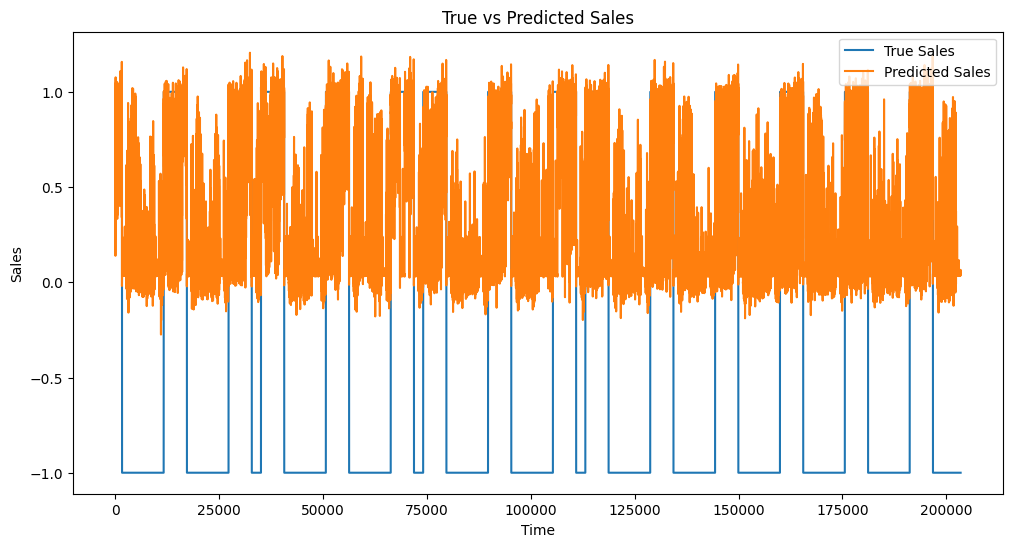

In [40]:
# Evaluate the model on the test data
mse = model.evaluate(X_test, y_test)
print("Mean Squared Error on Test Set:", mse)

# Predict on the test set
y_pred = model.predict(X_test)

# Reshape the predictions to match the shape of the original scaled 'Sales' column
y_pred_reshaped = y_pred.reshape(-1, 1)  # Reshape to (n_samples, 1) for inverse transformation

# Inverse scaling to get the original scale of sales (only for predictions)
y_pred_original = scaler.inverse_transform(np.concatenate([np.zeros((y_pred_reshaped.shape[0], scaled_data.shape[1]-1)), y_pred_reshaped], axis=1))[:, -1]

# Plot the predicted vs actual sales
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='True Sales')
plt.plot(y_pred_original, label='Predicted Sales')
plt.legend()
plt.title("True vs Predicted Sales")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.show()


 Monitor Model Training

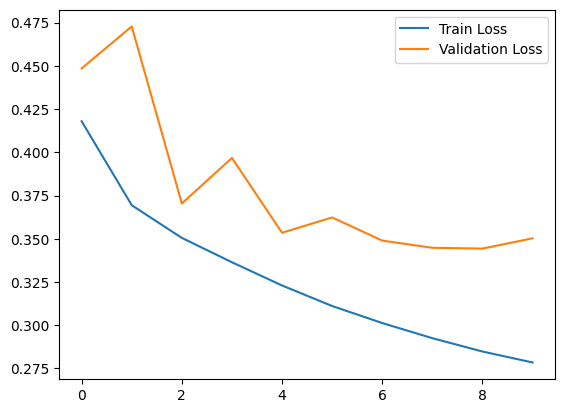

In [41]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()
